<a href="https://colab.research.google.com/github/jonaschen16/wafermap/blob/main/WM_811k_Wafermap_show.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F14180%2F19086%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240518%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240518T203545Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4b16281eafb86a6324bb47c28cf60618a771adc9227926be72b4c9d09bea7a2188167d74363e01b7972a596b1610556e46661a7ad8fba479d2c1d6e73a2ecb712ac650814fd5cb67745e8c3f14e65f0505d87333bc908d88d2de679053c756349073fcbbd7df982fde987d5b0873923f23517368ffe9c51cd8b4d2f97045e7044b9c4f47fe95db72b094b7f8c3c49951fda2e8debd805f186bb942d6f43045f2a93883019c8ec9cf36ab8b87f7fe1d9293eea0721fe89d27b2933252f5135d549cee6cbce91a6667a7aab420712a0858ce01a8e9e371a976264217ef61c2ae6003997ff65c6cc13ccf02126bfa370ca6da8f2f7ab9d45fccf6a2d4b761891047'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 156686283 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


Shows how machine learning is used in the semiconductor industry.

Purpose: Automatically identify failure patterns in the wafer map instead of manually. Through this, the yield of the manufacturing process in semiconductor production is improved.

input: kaggle WM-811K dataset

Model: one vs one multi-class classification model image detection system (splitting data with multiple classes into data with different classes and learning it with a binary classifier)

output: Failure pattern labels

In [2]:
# Load library

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt
%matplotlib inline

import os
print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

['LSWMD.pkl']


Data selection & preprocessing: Consider which data is usable, which data is lost, and which data can be deleted. Additionally, the selected data is organized through formatting, cleaning, and sampling.

- Data summary
- Target distribution
- Missing value check
- Others

In [3]:
!pwd

/content


In [4]:
# Data summary

df=pd.read_pickle("../input/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


- This dataset consists of information such as dieSize, lotName, waferIndex, and 811457 wafermaps.
- Both the training set and the test set have already been classified by experts. However, here it was ignored and redesigned.

list defect pattern

> 加入區塊引述符號



print('listing...')
n = np.size(df, axis=0)
with open('map_defect_list.csv', 'w') as file1:
    file1.write('map#,defect\n')
    for i in range(0, n):
        pattern = 0

        if 'none' in df['failureType'][i] or len(df['failureType'][i]) == 0:
            pattern = 0
        else:
            #print(i)
            file1.write(str(i))
            for ft in df['failureType'][i]:
            #    print(',', ft[0])
                file1.write(',' + ft[0])
            file1.write('\n')


print('done')



In [7]:
# Target distribution

df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [8]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


- This dataset was collected from 47543 real lots (set of 25 wafers) in the fab.
- However, there are 47543*25=1557325 wafers in 47543 lots, which is larger than the number of wafer maps of 811457. -> Let’s take a look at the data..

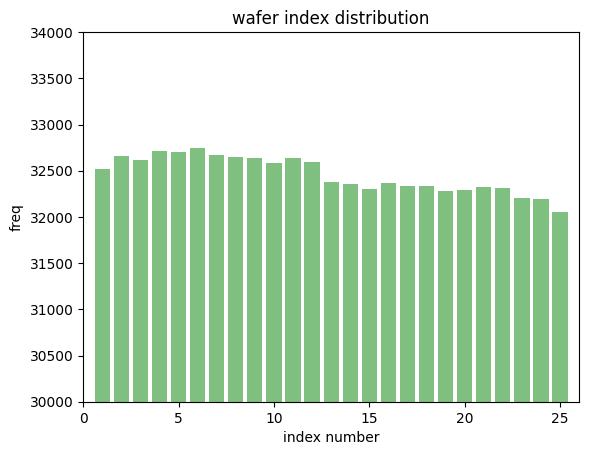

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='green', align='center', alpha=0.5)
plt.title("wafer index distribution")
plt.xlabel("index number")
plt.ylabel("freq")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

- Extract the number of unique values from an array using np.unique and return_counts=True.
- The index and its number are contained in uni_Index[0] and [1], respectively, and this is drawn as a bar graph.

- As a result, you can see that there are not 25 wafer maps in each lot. This may be due to sensor failure or other unknown problems.
- In our classification, there is no need for the wafer index feature, just drop the variable.

In [10]:
df=df.drop(['waferIndex'], axis=1)

- You can see that the die sizes are all different.
- So, let’s create a new variable ‘waferMapDim’ and use it.

In [11]:
def find_dim(x):
    dim0=np.size(x, axis=0)
    dim1=np.size(x, axis=1)
    return dim0, dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
261383,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2847.0,lot16170,[],[],"(63, 58)"
308341,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",1139.0,lot18783,[],[],"(38, 38)"
679584,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1,...",845.0,lot42193,[[Test]],[[none]],"(35, 31)"
704241,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,...",516.0,lot43194,[[Training]],[[none]],"(25, 27)"
353962,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1507.0,lot21140,[],[],"(43, 44)"


In [12]:
max(df.waferMapDim), min(df.waferMapDim)

((300, 202), (6, 21))

In [13]:
uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
uni_waferDim[0].shape[0]

632

- When I saw that the min and max values of the dimensions of the wafer map were different, I could see that the sizes were all different.
- It was also found that there were 632 different sizes.

Now it’s time to check for missing data.

- Missing values may result in useless values.
- Checking missing values is very important in the data preprocessing process.
- Since we are only interested in wafers with patterns in the first place, we can delete data without a failure type label.

In [14]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3, 'Loc':4, 'Random':5,'Scratch':6, 'Near-full':7, 'none':8}
mapping_traintest={'Training':0, 'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [15]:
tol_wafers=df.shape[0] # return number of rows
tol_wafers

811457

In [16]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)] # Create a new data frame
df_withlabel = df_withlabel.reset_index() # Reset the index of the data frame created earlier
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)] # Create a new data frame
df_withpattern = df_withpattern.reset_index() # Reset data frame index
df_nonpattern = df[(df['failureNum']==8)] # Create a new data frame
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0] # Returns the number of rows in each data frame

(172950, 25519, 147431)

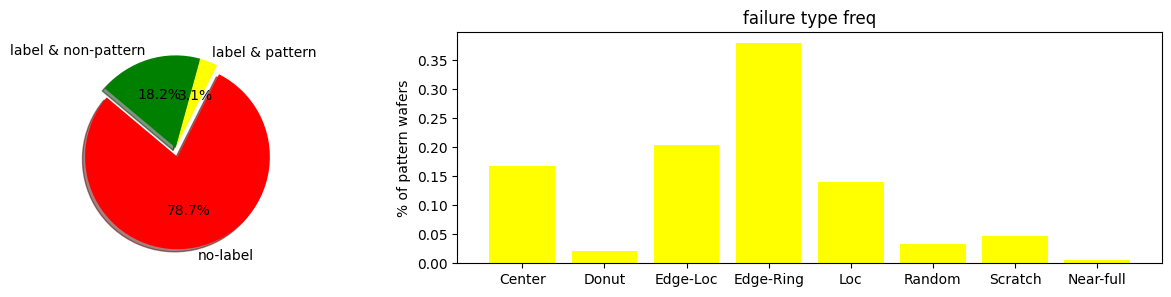

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
figure = plt.figure(figsize=(15,3))
gridspec = gridspec.GridSpec(1, 2, width_ratios=[1,2])
ax1 = plt.subplot(gridspec[0])
ax2 = plt.subplot(gridspec[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['red', 'yellow', 'green']
explode = (0.1, 0, 0)
labels = ['no-label', 'label & pattern', 'label & non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2=['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='yellow', align='center', alpha=1)
ax2.set_title("failure type freq")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

- Looking at the results, 172950 wafers are labeled. However, the remaining 78.7% of wafers were not labeled.
- Among the labeled wafers, 25519 wafers (3.1%) have a failure pattern, but the remaining 147431 wafers are still intact. In the end, I think we should only focus on 25519...
- There are various failure types

- I think I need to do some data visualization to see the data at a glance.
- Let's pick a few of the labeled ones and take a look.

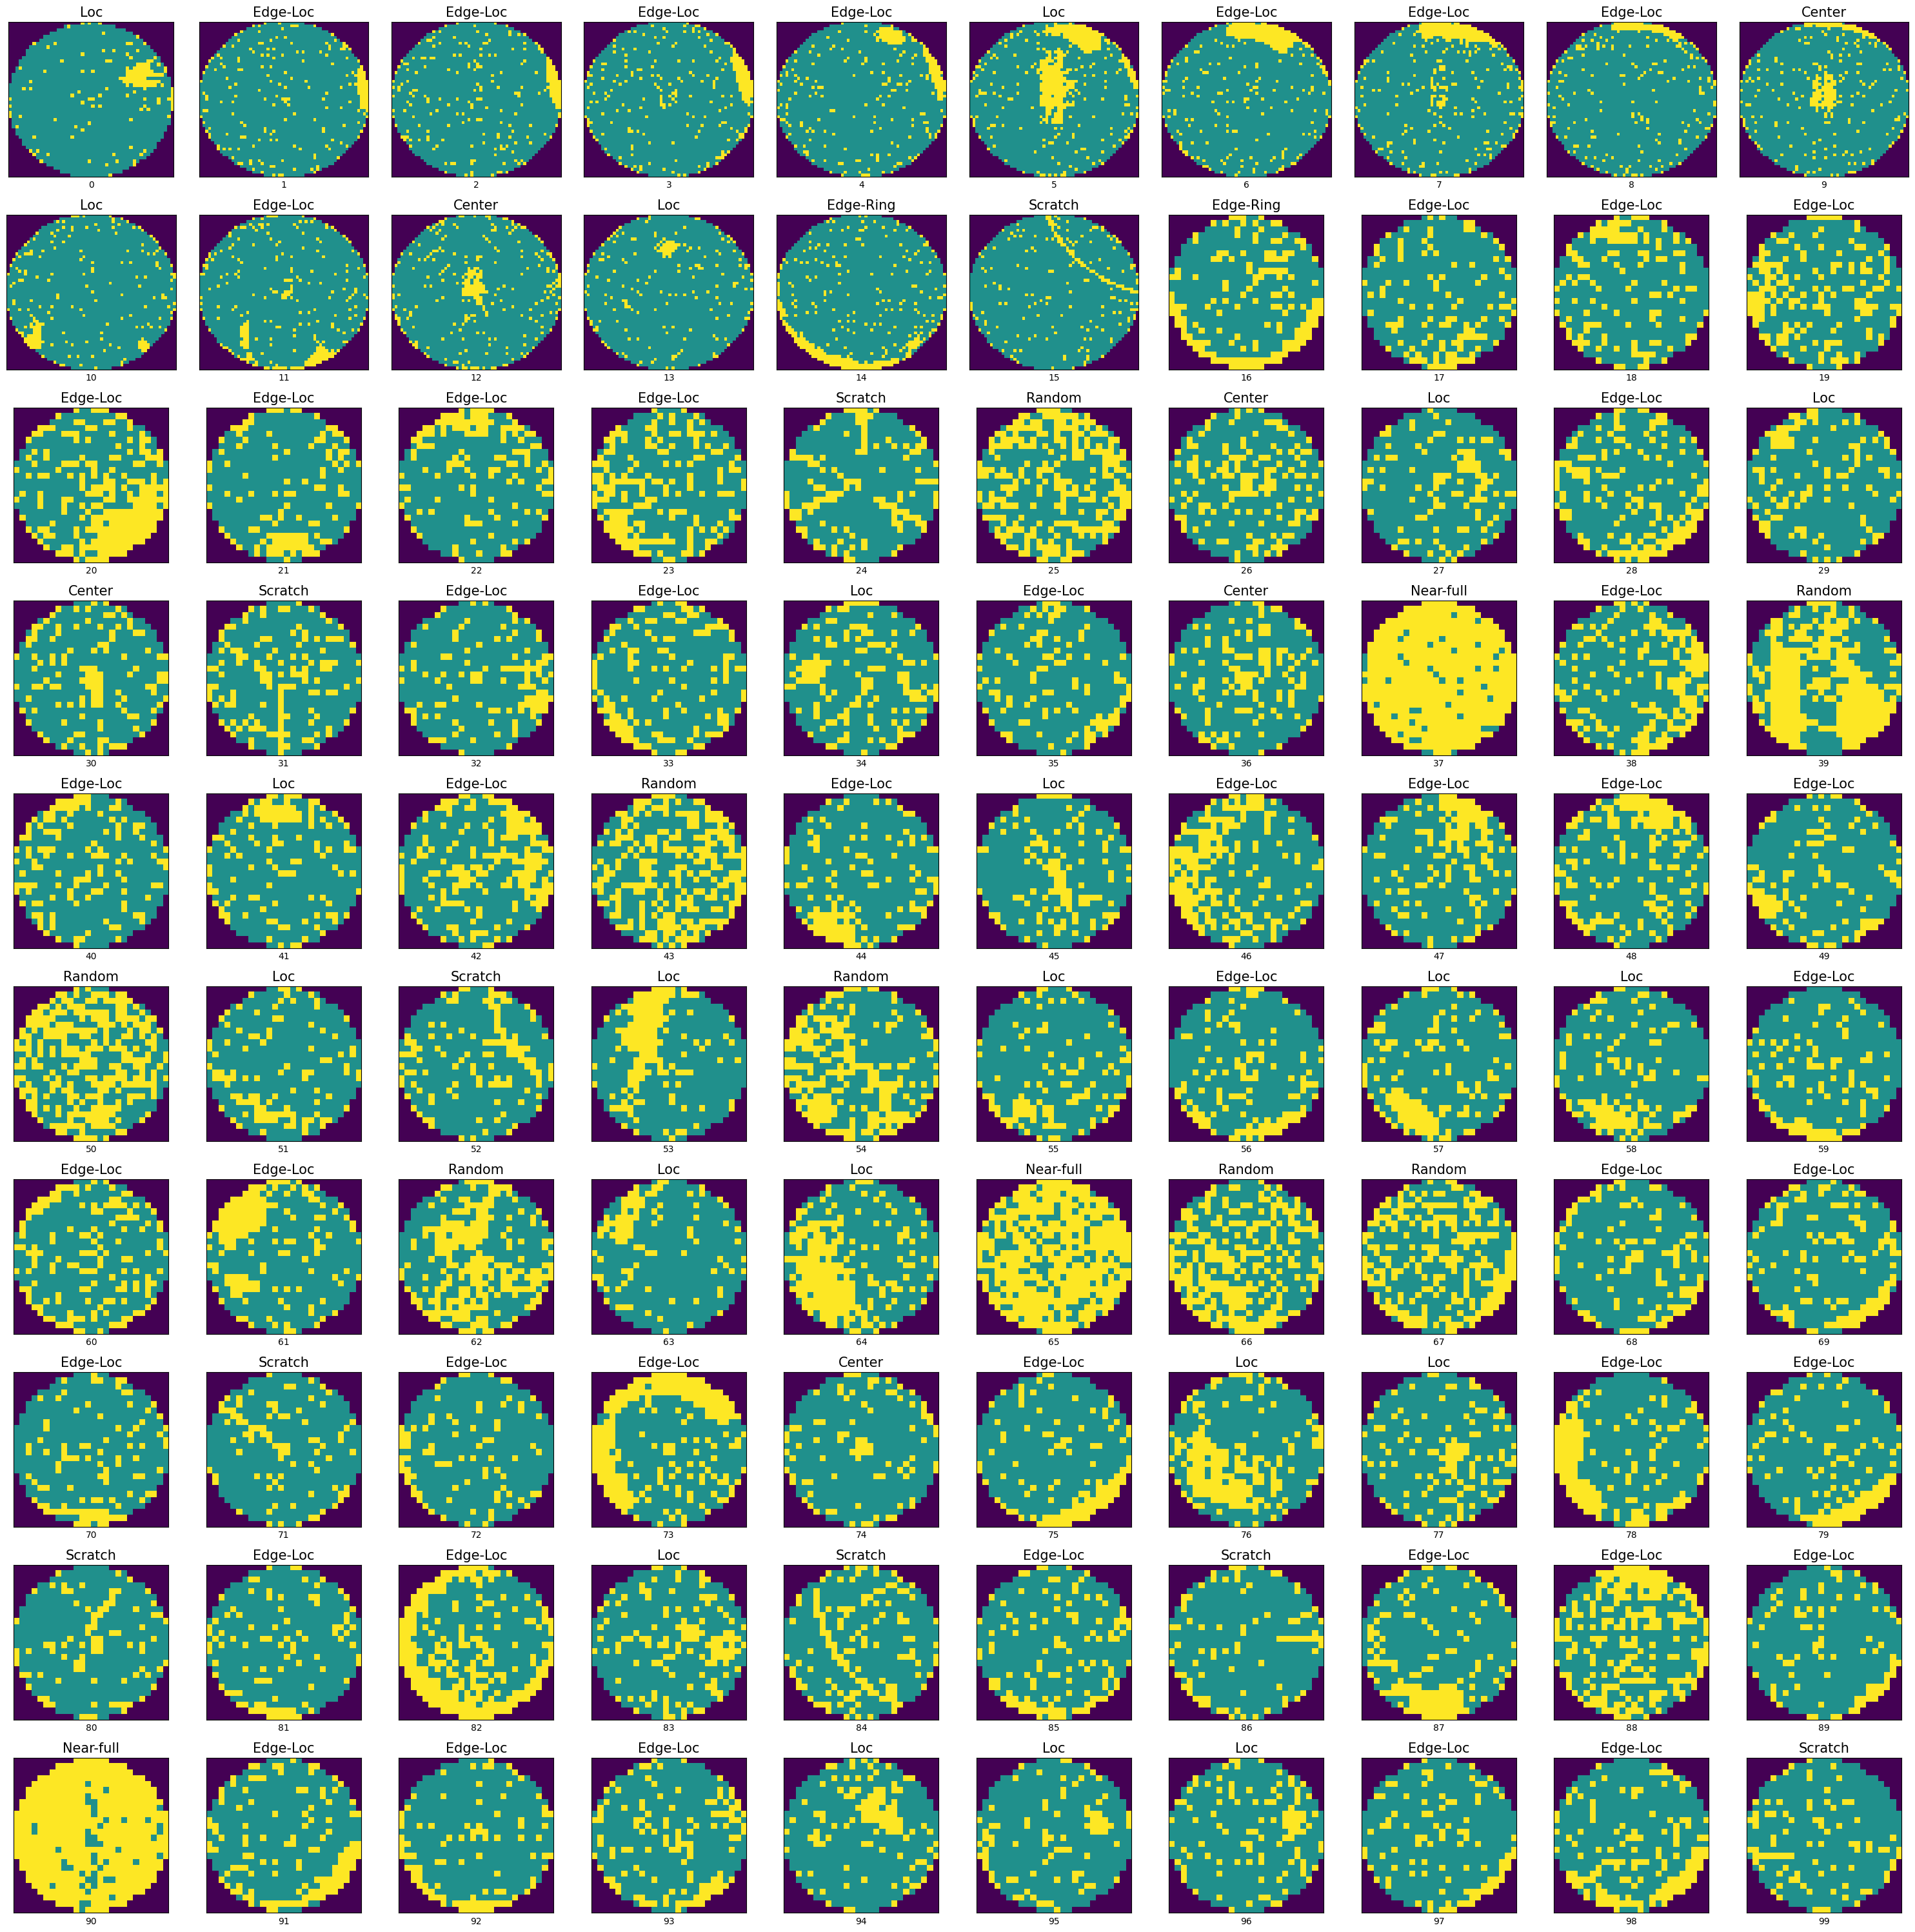

In [18]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(30, 30))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withpattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=15)
    ax[i].set_xlabel(df_withpattern.index[i], fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

In [61]:
#mapping_type={'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3, 'Loc':4, 'Random':5,'Scratch':6, 'Near-full':7, 'none':8}
#mapping_traintest={'Training':0, 'Test':1}

df_show = df[(df['failureNum']==0) & (df.waferMapDim >= (40,40))] # Create a new data frame
df_show = df_show.reset_index() # Reset the index of the data frame created earlier

In [57]:
df_show.head()

,index,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,134,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot6,[[Training]],[[Scratch]],"(53, 58)",6,0
1,7849,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5258.0,lot1411,[[Training]],[[Scratch]],"(102, 66)",6,0
2,14210,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3927.0,lot2157,[[Training]],[[Scratch]],"(69, 73)",6,0
3,16958,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6295.0,lot2315,[[Training]],[[Scratch]],"(113, 71)",6,0
4,22274,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7874.0,lot2556,[[Training]],[[Scratch]],"(118, 84)",6,0


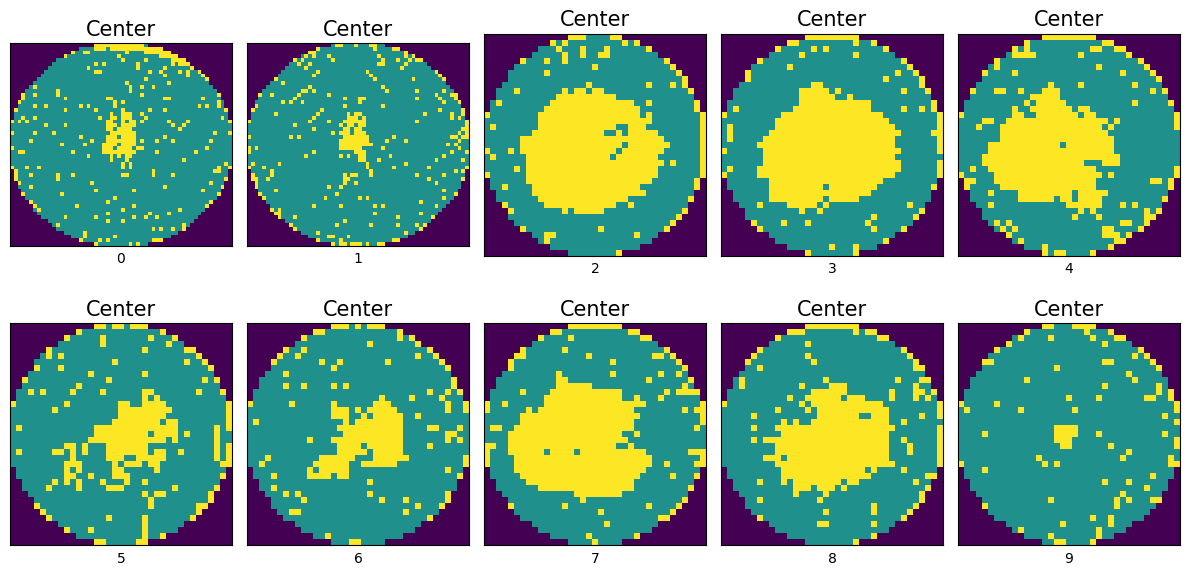

In [70]:
#map_list = [19,36,37,19,36,37,19,36,37,19]
#mapping_type={'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3, 'Loc':4, 'Random':5,'Scratch':6, 'Near-full':7, 'none':8}
#mapping_traintest={'Training':0, 'Test':1}

df_show = df[(df['failureNum']==0) & (df.waferMapDim >= (30,30))] # Create a new data frame
df_show = df_show.reset_index() # Reset the index of the data frame created earlier

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(12,6))
ax = ax.ravel(order='C')
i = 0
for m in range(10):
    img = df_show.waferMap[m]
    ax[i].imshow(img)
    ax[i].set_title(df_show.failureType[m][0][0], fontsize=15)
    ax[i].set_xlabel(df_show.index[m], fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    i = i+1

plt.tight_layout()
plt.show()

- Appears in 6 types: Log, Edge-Loc, Center, Near-full, Scratch, and Random.

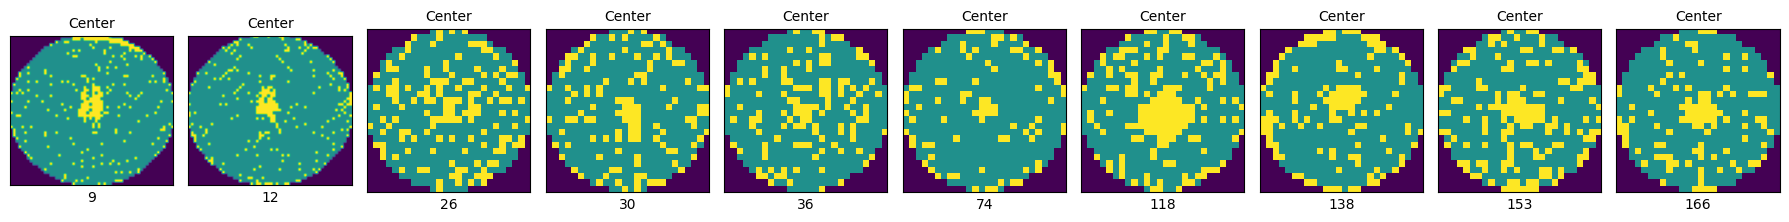

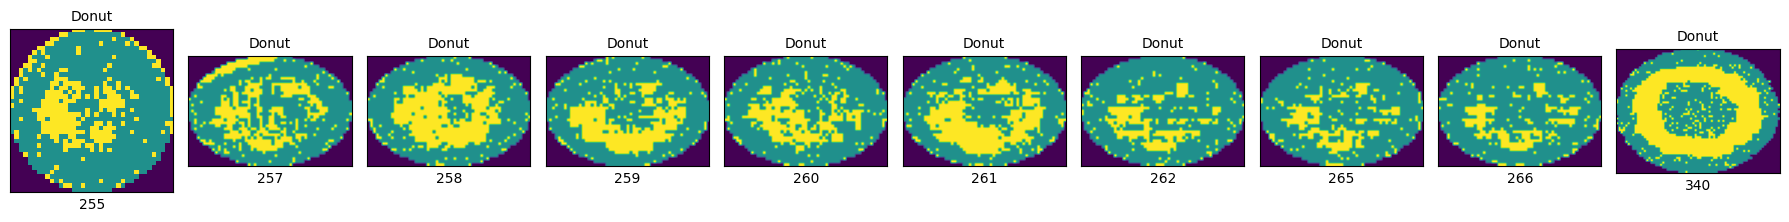

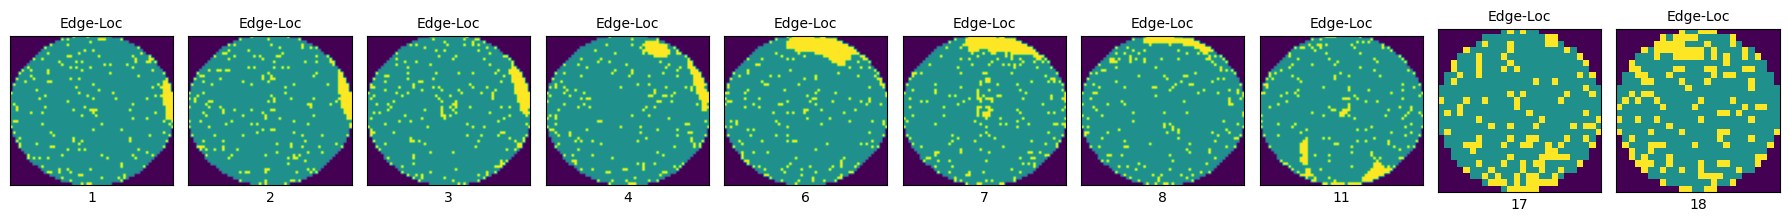

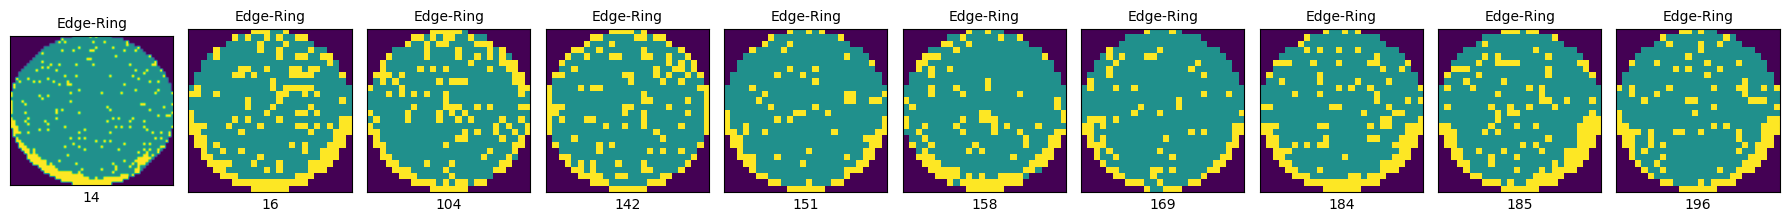

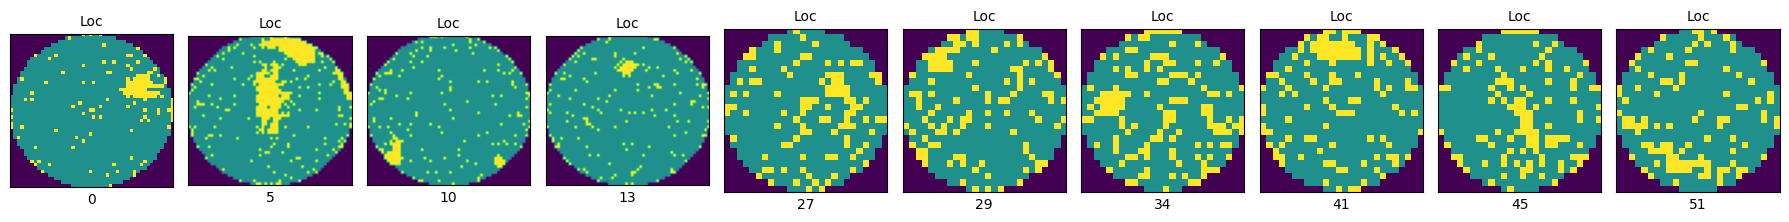

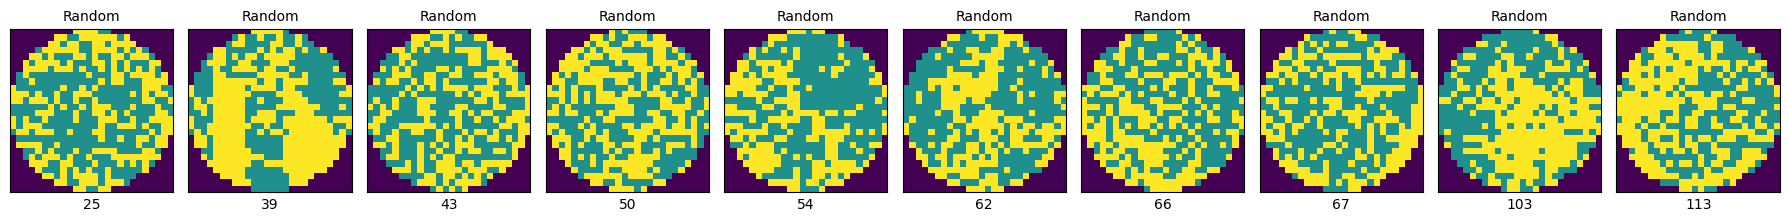

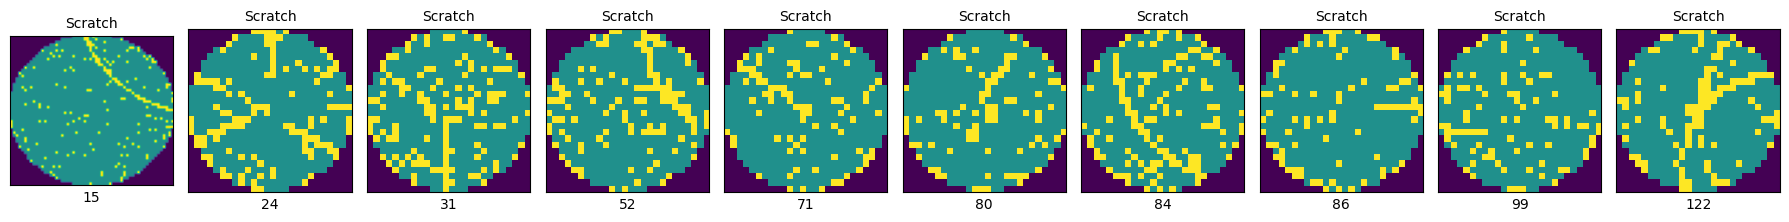

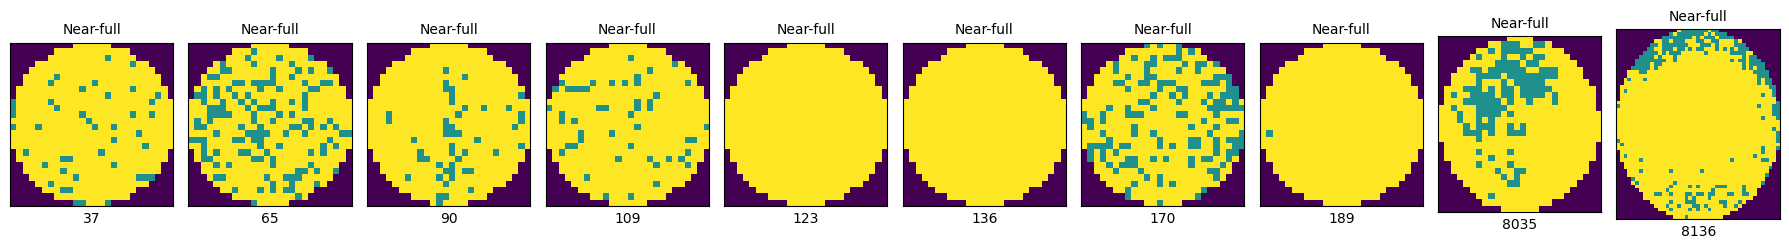

In [20]:
x=[0,1,2,3,4,5,6,7]
labels2=['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for i in x:
    fig, ax=plt.subplots(nrows=1, ncols=10, figsize=(18,12))
    ax=ax.ravel(order='C') # ravel changes multi-dimensional array to 1-dimensional, C is default
    for j in [i]:
        img=df_withpattern.waferMap[df_withpattern.failureType==labels2[j]]
        for k in range(10):
            ax[k].imshow(img[img.index[k]])
            ax[k].set_title(df_withpattern.failureType[img.index[k]][0][0], fontsize=10)
            ax[k].set_xlabel(df_withpattern.index[img.index[k]], fontsize=10)
            ax[k].set_xticks([])
            ax[k].set_yticks([])
    plt.tight_layout()
    plt.show()

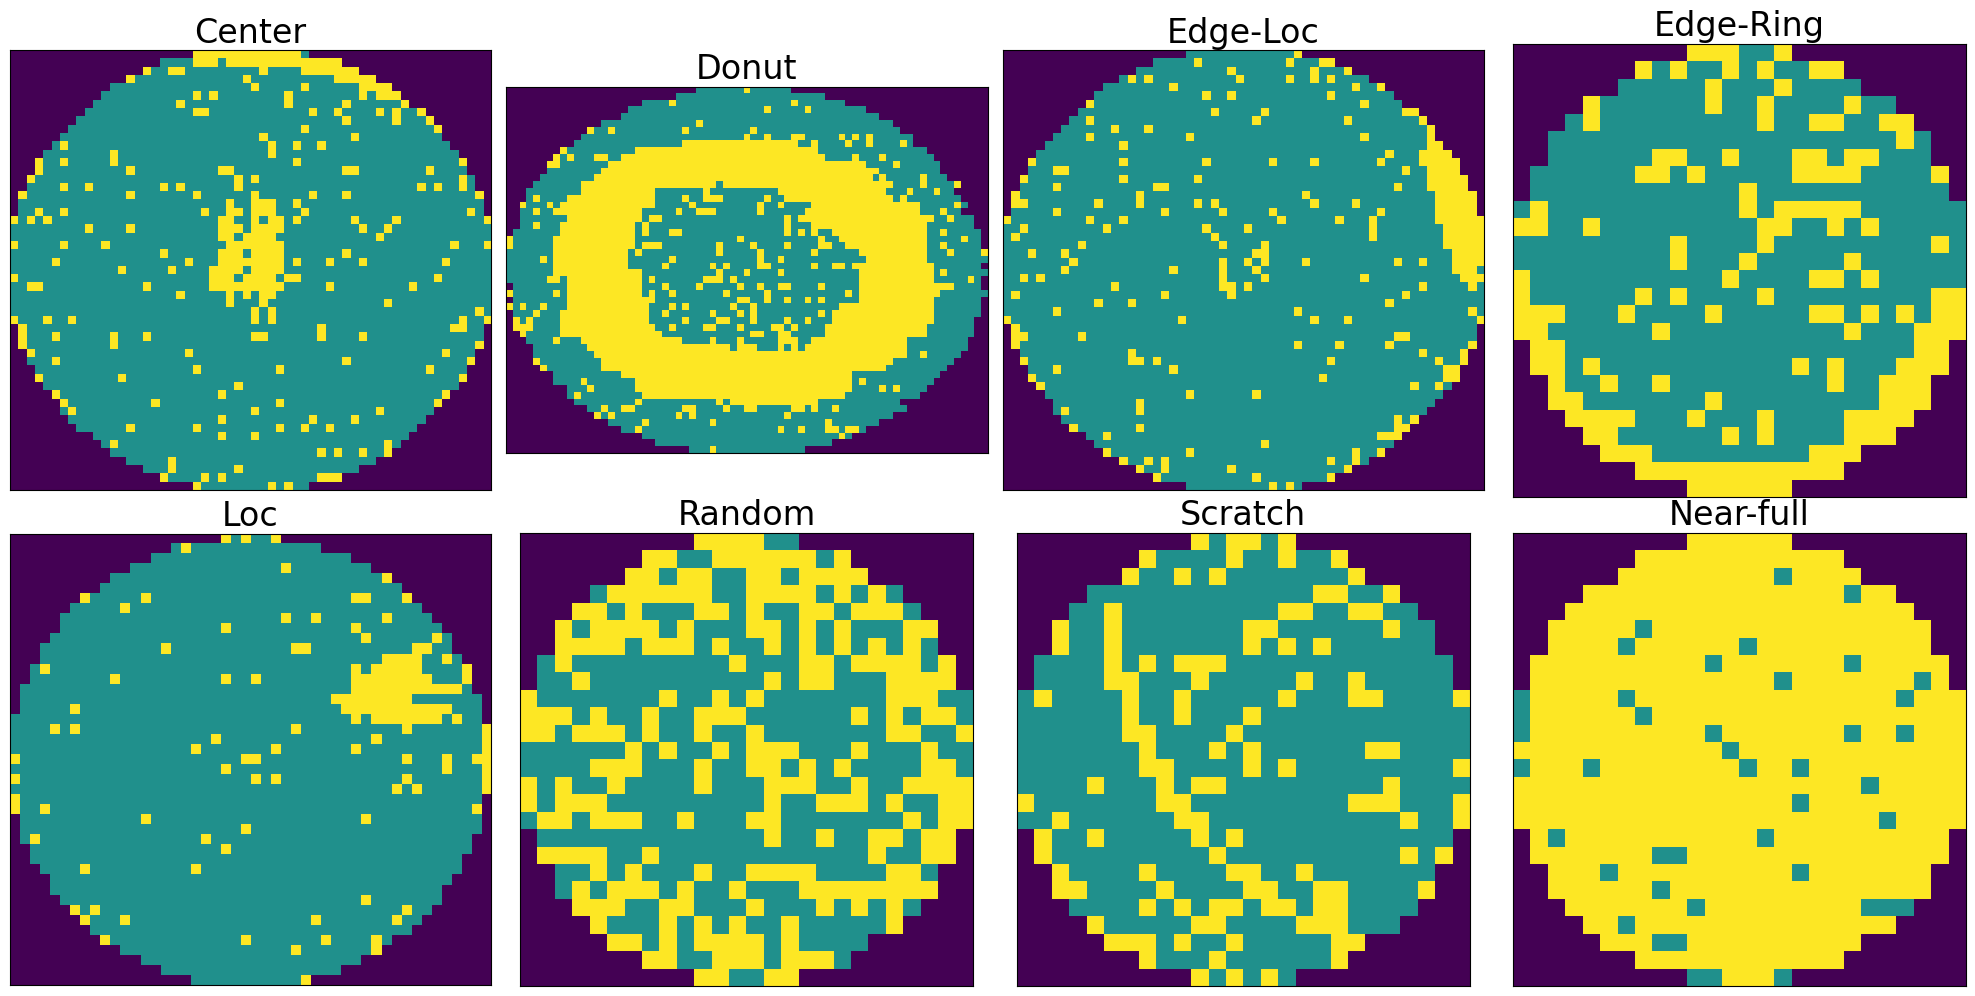

In [21]:
x=[9, 340, 3, 16, 0, 25, 84, 37]
labels2=['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig,ax=plt.subplots(nrows=2, ncols=4, figsize=(20,10))
ax=ax.ravel(order='C')
for i in range(8):
    img=df_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0], fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

Now let's transform the data.
- Data transformation: It seems that a process of preprocessing data is necessary for machine learning.